In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import (Input, 
                                     Add, 
                                     Dense, 
                                     Activation, 
                                     ZeroPadding2D, 
                                     BatchNormalization, 
                                     Flatten, 
                                     Conv2D, 
                                     AveragePooling2D, 
                                     MaxPooling2D,
                                     GlobalAveragePooling2D, 
                                     Dropout)
from tensorflow.keras.callbacks import (ReduceLROnPlateau, 
                                        EarlyStopping, 
                                        ModelCheckpoint)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-05-19 17:18:37.278822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 17:18:37.692528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-05-19 17:18:38.292599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 17:18:38.307129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 17:18:38.307473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
# Manage Logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# The TF_CPP_MIN_LOG_LEVEL variable can take the following values:

# '0': Display all logs (default behavior)
# '1': Display only warning and error logs
# '2': Display error logs only
# '3': Do not display any logs


### Helpers

In [3]:
def generate_filename(filename):
    """
    Generates a filename with a timestamp.

    Args:
        filename (str): The original filename.

    Returns:
        str: The new filename.
    """
    timestamp = datetime.now().strftime("%d%m%Y-%H%M%S")
    return f"{timestamp}_{filename}"

## Load Train and Test Datasets

In [13]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)


Found 1712 images belonging to 2 classes.
Found 427 images belonging to 2 classes.
Found 4279 images belonging to 2 classes.


[1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1.]


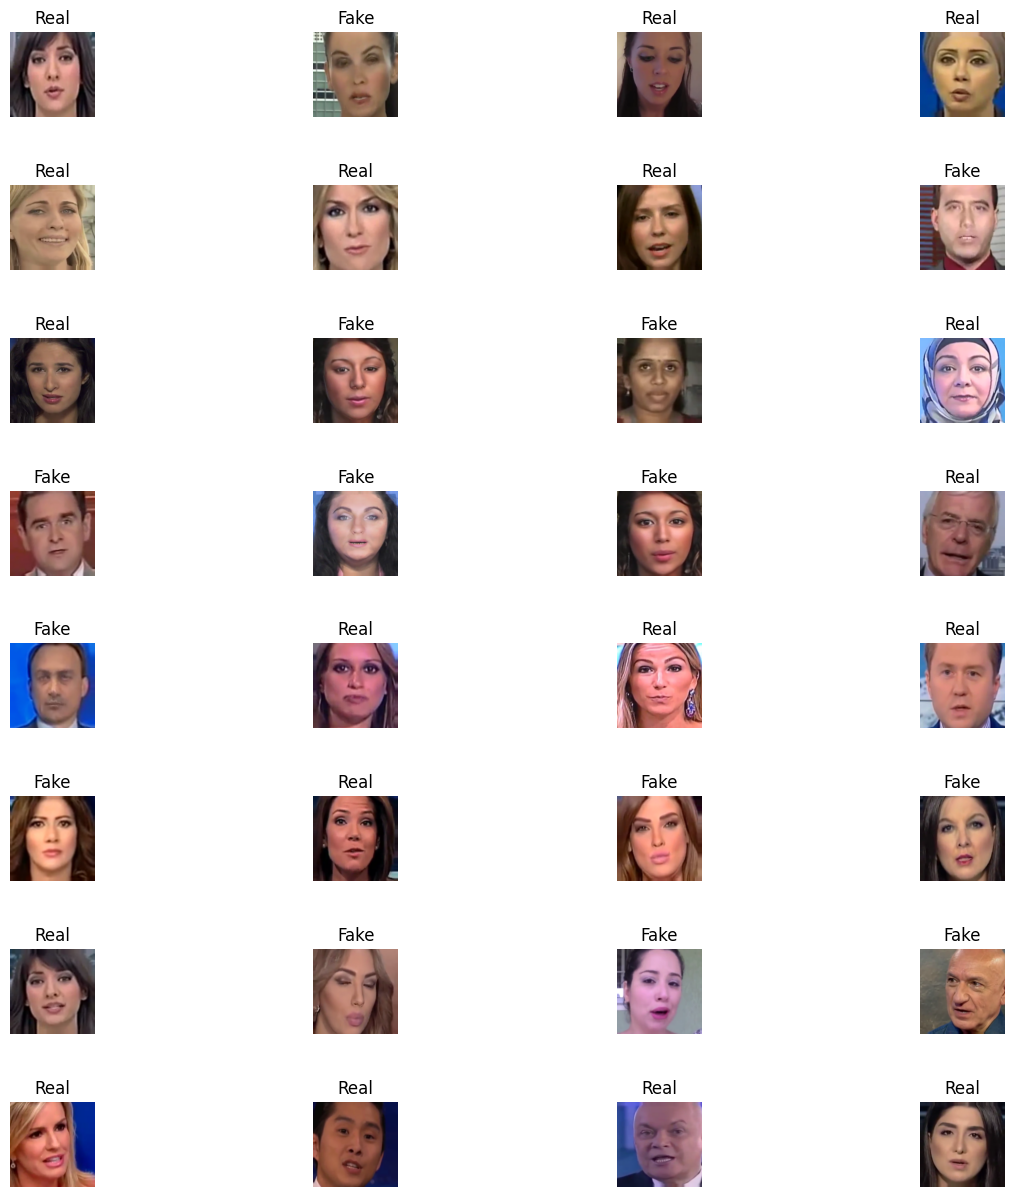

In [14]:
# Import first 32 images (first batch)
train_images, train_labels = next(train_ds)
print(train_labels)

# Redefine labels
label_names = {0: 'Fake', 1: 'Real'}

# Show some of our samples
# Define length and width of our figure
L = 8
W = 4

fig, axes = plt.subplots(L, W, figsize=(15, 15))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[train_labels[i]])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.8)

In [15]:
# Define Callback Methods
# Stop training when a monitored metric has stopped improving.
early_stopping_a = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 1, 
    patience = 5
)

# Reduce learning rate when a metric has stopped improving
reduce_lr_a = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.3, #was 0.5 
                              patience = 5, #was 2 and got 8 epochs 
                              min_lr = 1e-15 
                              )

base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.


base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# headmodel = basemodel.output
# headmodel = GlobalAveragePooling2D()(headmodel)
# headmodel = Dense(2048, activation = 'relu')(headmodel)
# headmodel = Dropout(0.2)(headmodel)
# headmodel = Dense(1, activation = 'sigmoid')(headmodel)
#model = Model(inputs = basemodel.input, outputs = headmodel)


model.compile(
    optimizer=keras.optimizers.Adam(),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
(print(f"Please print: {train_ds.batch_size}"))
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
val_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# Fit the model
history_top = model.fit(train_ds, 
                    steps_per_epoch=train_ds.samples // train_ds.batch_size,
                    epochs=50, 
                    validation_data=val_ds,
                    validation_steps=val_ds.samples // val_ds.batch_size,
                    callbacks=[early_stopping_a, reduce_lr_a])


# basemodel.save('models/xception_basemodel_b32_v2.h5')
# model.save('models/xception_model_b32_v2.h5')


# # freeze all layers except last 23, weights of last 23 layers we be updated
for layer in basemodel.layers[:23]:
   layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

# Fit the model
history_whole = model.fit(train_ds, 
                    steps_per_epoch=train_ds.samples // train_ds.batch_size,
                    epochs=50, 
                    validation_data=val_ds,
                    validation_steps=val_ds.samples // val_ds.batch_size,
                    callbacks=[early_stopping_a, reduce_lr_a])

basemodel.save('models/xception_basemodel_b32_v2_pt2.h5')
model.save('models/xception_model_b32_v2_pt2.h5')

Epoch 1/50


2023-05-20 10:39:32.268885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26/53 [=============>................] - ETA: 9s - loss: 0.7012 - binary_accuracy: 0.5012 

KeyboardInterrupt: 

In [ ]:
# Define Callback Methods
# Stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 1, 
    patience = 5
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.2, #was 0.5 
                               patience = 5, #was 2 and got 8 epochs 
                              min_lr = 1e-15 
                              )


# Define basemodel from Xception
basemodel = Xception(weights = 'imagenet', 
                     include_top = False,  # Do not include the ImageNet classifier at the top
                     input_tensor = Input(shape = (299, 299, 3)))

# freeze all layers except last 23, weights of last 23 layers we be updated
for layer in basemodel.layers[:-23]:
    layer.trainable = False


# See architecture of our basemodel
#basemodel.summary()

batch_size =32

headmodel = basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Dense(2048, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)


# Group the basemodel and new fully-connected layers into a Model object
model = Model(inputs = basemodel.input, outputs = headmodel)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy()],
)


# Fit the model
history = model.fit(train_ds, 
                    steps_per_epoch=train_ds.samples // batch_size,
                    epochs=50, 
                    validation_data=val_ds,
                    validation_steps=val_ds.samples // batch_size,
                    callbacks=[early_stopping, reduce_lr])

In [9]:
# Define Callback Methods
# Stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 1, 
    patience = 5
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.2, #was 0.5 
                               patience = 5, #was 2 and got 8 epochs 
                              min_lr = 1e-15 
                              )


# Define basemodel from Xception
basemodel = Xception(weights = 'imagenet', 
                     include_top = False,  # Do not include the ImageNet classifier at the top
                     input_tensor = Input(shape = (299, 299, 3)))

# # freeze all layers except last 23, weights of last 23 layers we be updated
# for layer in basemodel.layers[:23]:
#    layer.trainable = False

basemodel.trainable = False

# See architecture of our basemodel
#basemodel.summary()

batch_size = 32

headmodel = basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Dense(2048, activation = 'relu')(headmodel)basemodel.save('models/xception_basemodel_b32_v2.h5')
# model.save('models/xception_model_b32_v2.h5')
)


# Fit the model
history = model.fit(train_ds, 
                    steps_per_epoch=train_ds.samples // batch_size,
                    epochs=50, 
                    validation_data=val_ds,
                    validation_steps=val_ds.samples // batch_size,
                    callbacks=[early_stopping, reduce_lr])

basemodel.save('models/xception_basemodel_b32_v1.h5')
model.save('models/xception_model_b32_v1.h5')

# # freeze all layers except last 23, weights of last 23 layers we be updated
for layer in basemodel.layers[:23]:
   layer.trainable = False

model.trainable = False

# Fit the model
history = model.fit(train_ds, 
                    steps_per_epoch=train_ds.samples // batch_size,
                    epochs=50, 
                    validation_data=val_ds,
                    validation_steps=val_ds.samples // batch_size,
                    callbacks=[early_stopping, reduce_lr])

basemodel.save('models/xception_basemodel_b32_v1_pt2.h5')
model.save('models/xception_model_b32_v1_pt2.h5')



Epoch 1/50


2023-05-19 22:09:53.122026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


6036/6036 [==============================] - ETA: 0s - loss: 0.6002 - binary_accuracy: 0.6794

2023-05-19 22:46:15.935725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


6036/6036 [==============================] - 2727s 451ms/step - loss: 0.6002 - binary_accuracy: 0.6794 - val_loss: 0.7637 - val_binary_accuracy: 0.5641 - lr: 0.0010
Epoch 2/50
6036/6036 [==============================] - 2721s 451ms/step - loss: 0.5231 - binary_accuracy: 0.7370 - val_loss: 0.7988 - val_binary_accuracy: 0.5680 - lr: 0.0010
Epoch 3/50
6036/6036 [==============================] - 2726s 452ms/step - loss: 0.4771 - binary_accuracy: 0.7678 - val_loss: 0.8908 - val_binary_accuracy: 0.5538 - lr: 0.0010
Epoch 4/50
6036/6036 [==============================] - 2715s 450ms/step - loss: 0.4508 - binary_accuracy: 0.7855 - val_loss: 1.0247 - val_binary_accuracy: 0.5282 - lr: 0.0010
Epoch 5/50
6036/6036 [==============================] - 2711s 449ms/step - loss: 0.4303 - binary_accuracy: 0.7977 - val_loss: 1.0068 - val_binary_accuracy: 0.5223 - lr: 0.0010
Epoch 6/50
6036/6036 [==============================] - 2709s 449ms/step - loss: 0.4092 - binary_accuracy: 0.8086 - val_loss: 0.970

2023-05-20 02:41:42.844583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


6036/6036 [==============================] - ETA: 0s - loss: 0.3649 - binary_accuracy: 0.8359

2023-05-20 03:17:56.441153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


6036/6036 [==============================] - 2718s 450ms/step - loss: 0.3649 - binary_accuracy: 0.8359 - val_loss: 1.2282 - val_binary_accuracy: 0.5244 - lr: 2.0000e-04
Epoch 2/50
6036/6036 [==============================] - 2705s 448ms/step - loss: 0.3468 - binary_accuracy: 0.8446 - val_loss: 1.2778 - val_binary_accuracy: 0.5220 - lr: 2.0000e-04
Epoch 3/50
6036/6036 [==============================] - 2709s 449ms/step - loss: 0.3379 - binary_accuracy: 0.8502 - val_loss: 1.3006 - val_binary_accuracy: 0.5169 - lr: 2.0000e-04
Epoch 4/50
6036/6036 [==============================] - 2707s 448ms/step - loss: 0.3308 - binary_accuracy: 0.8528 - val_loss: 1.2999 - val_binary_accuracy: 0.5227 - lr: 2.0000e-04
Epoch 5/50
6036/6036 [==============================] - 2702s 448ms/step - loss: 0.3216 - binary_accuracy: 0.8585 - val_loss: 1.3354 - val_binary_accuracy: 0.5207 - lr: 2.0000e-04
Epoch 6/50
6036/6036 [==============================] - 2736s 453ms/step - loss: 0.3148 - binary_accuracy: 0.86

In [6]:
model.save('xception_model-batchsize-64.h5')